In [25]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'       # selecting gpu!

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tensorflow import keras as k
from tensorflow.keras import layers

from sklearn.manifold import TSNE
import seaborn as sns


print(tf.__version__)
print(k.__version__)
print(tf.test.is_gpu_available())

1.14.0
2.2.4-tf
False


In [2]:
# Loading MNIST
(train_images, y_tr), (test_images, y_te) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_tr,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_te,num_classes=10)


# train_images[train_images >= .5] = 1.
# train_images[train_images < .5] = 0.
# test_images[test_images >= .5] = 1.
# test_images[test_images < .5] = 0.

## You can uncomment above and use binary cross entropy loss as reconstruction loss.

print(train_images.shape,y_train.shape,test_images.shape,y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [20]:
BATCH_SIZE = 128
LATENT_DIM = 2
LEARNING_RATE = 0.001
EPOCHS = 200
INPUT_SHAPE = 784
CONDITION_SIZE = 10

In [8]:
# sampling
def sampling(args, latent_dim=LATENT_DIM):
    mean, log_var = args
    eps = tf.random_normal(shape=(tf.shape(mean)[0], latent_dim), mean=0., stddev=1.0)
    return mean + tf.exp(log_var/2.) * eps


## encoder
def make_encoder(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM, condition_size=CONDITION_SIZE, batch_size=BATCH_SIZE):
    x = layers.Input(shape=(input_shape,))
    c = layers.Input(shape=(condition_size,))
    inputs = layers.concatenate([x,c],axis=1)
    h = layers.Dense(units=512,activation='relu')(inputs)
    h = layers.Dense(units=256,activation='relu')(h)
    mean = layers.Dense(units=latent_dim)(h)
    log_var = layers.Dense(units=latent_dim)(h)
    return k.Model(inputs=[x,c],outputs=[mean,log_var], name='encoder')


## decoder
def make_decoder(output_shape=INPUT_SHAPE, batch_size=BATCH_SIZE, latent_dim=LATENT_DIM, condition_size=CONDITION_SIZE):

    z = layers.Input(shape=(latent_dim,))
    c = layers.Input(shape=(condition_size,))
    con = layers.concatenate([z, c], axis=1)
    h1 = layers.Dense(units=256,activation='relu')(con)
    h2 = layers.Dense(units=512,activation='relu')(h1)
    y = layers.Dense(units=output_shape,activation='sigmoid')(h2)
    return k.Model(inputs=[z,c],outputs=y, name='decoder')

## loss
def loss(x, y, mean, log_var, alpha=1.0, beta=1.0):
    reconstruction_loss = k.losses.mean_squared_error(y_true=x, y_pred=y)
    reconstruction_loss = tf.reduce_mean(reconstruction_loss, name='recon_loss')
    kl_loss = - 0.5 * tf.reduce_mean(log_var - tf.square(mean) - tf.exp(log_var) + 1)
    kl_loss = tf.identity(kl_loss, name="kl_loss")
    cvae_loss = alpha*reconstruction_loss + beta*kl_loss
    return cvae_loss

In [21]:
# making encoder and decoder models
encoder = make_encoder()
print(encoder.summary(),'\n\n*******************************************************************************************************\n\n')
decoder = make_decoder()
print(decoder.summary(),'\n\n*******************************************************************************************************\n\n')


# CVAE all together!
x = layers.Input(shape=(INPUT_SHAPE,))
c = layers.Input(shape=(CONDITION_SIZE,))
mean, log_var = encoder([x,c])
z = layers.Lambda(sampling)([mean, log_var])
y = decoder([z,c])

cvae = k.Model(inputs=[x, c], outputs=y, name='cvae')
cvae.add_loss(loss(x,y,mean,log_var,alpha=10))
cvae.compile(optimizer=k.optimizers.Adam(LEARNING_RATE))
print(cvae.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 794)          0           input_65[0][0]                   
                                                                 input_66[0][0]                   
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 512)          407040      concatenate_22[0][0]       

W1203 21:09:50.855772 4680623552 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 539396      input_69[0][0]                   
                                                                 input_70[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 2)            0           encoder[1][0]                 

In [22]:
## train
cvae.fit((train_images,y_train),epochs=300, batch_size=BATCH_SIZE)

Epoch 1/30
10/10 [==============================] - 31s 3s/step - loss: 2.0756
Epoch 2/30
10/10 [==============================] - 36s 4s/step - loss: 0.9614
Epoch 3/30
10/10 [==============================] - 37s 4s/step - loss: 0.7003
Epoch 4/30
10/10 [==============================] - 33s 3s/step - loss: 0.6786
Epoch 5/30
10/10 [==============================] - 31s 3s/step - loss: 0.6596
Epoch 6/30
10/10 [==============================] - 32s 3s/step - loss: 0.6395
Epoch 7/30
 1/10 [==>...........................] - ETA: 27s - loss: 0.6279

KeyboardInterrupt: 

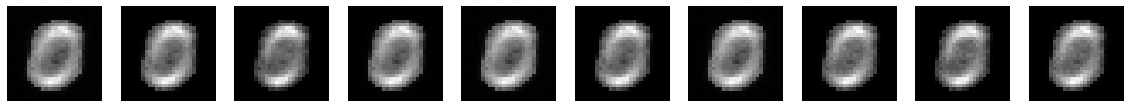

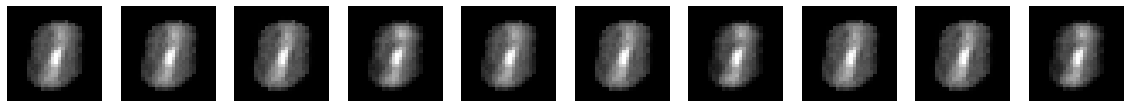

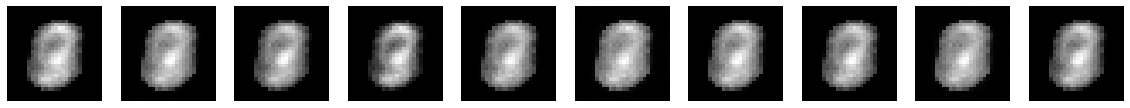

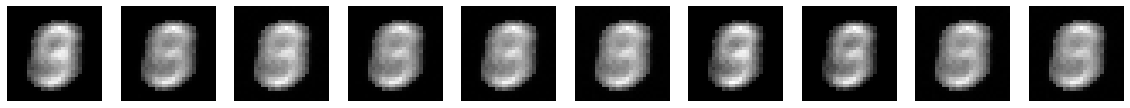

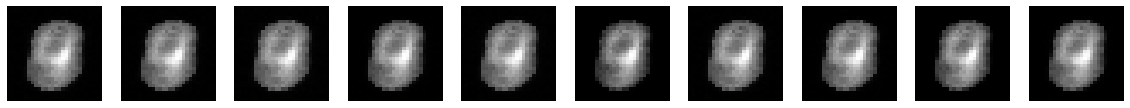

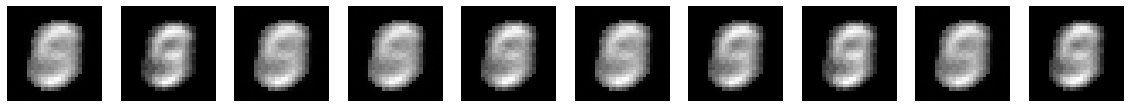

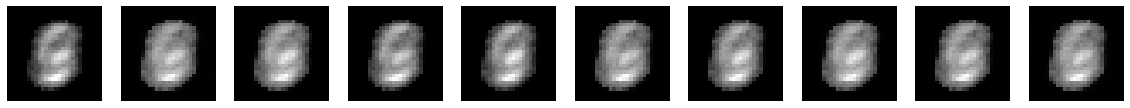

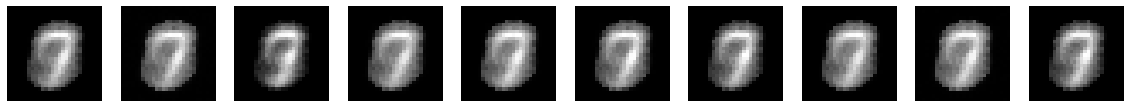

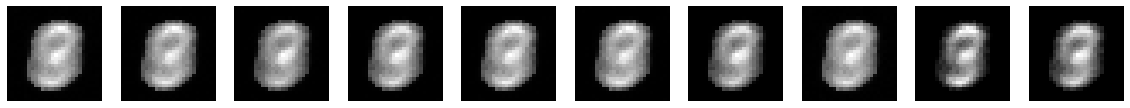

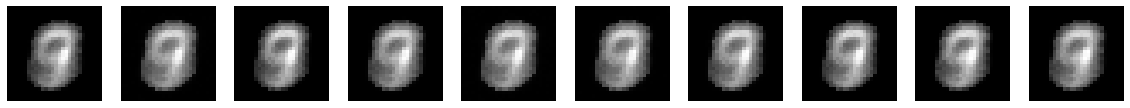

In [23]:
## plot generated images

for cond_number in range(10):
    cond_vec = k.utils.to_categorical(cond_number, 10).reshape(1,-1)
    z_sample = tf.random.normal(shape=(10,LATENT_DIM))
    generated = decoder.predict([z_sample, np.repeat(cond_vec,10,axis=0)],steps=1).reshape(10,28, 28)
    plt.figure(figsize=(20, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(generated[i,:,:], cmap='gray')

plt.show()


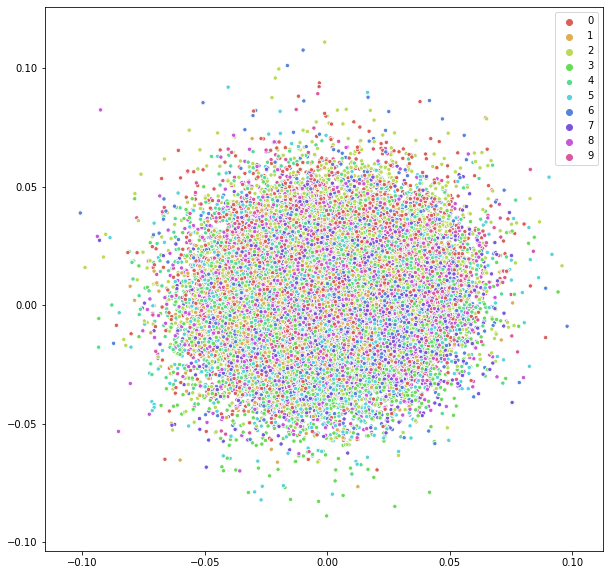

In [31]:
## plot latent space
n = 60000
mean, logvar = encoder.predict([train_images[:n,:],y_train[:n,:]])
label = np.argmax(y_train[:n,:], 1)
cmap = sns.color_palette("hls", 10)
plt.figure(figsize=(10,10))
sns.scatterplot(x=mean[:,0], y=mean[:,1], hue=label, size=5,palette=cmap)
plt.show()